# Lab 10


# Part 1 - Setup

In [1]:
!docker run -d --name nginx --network=none -p 81:81 nginx

4b9e4ecfb961d75b2dc3fc0ae172926eec8efa250e7742b7e6c7ec56350e1889


Error:
- docker: error during connect: Head
Solution: 
- Start docker desktop

Error:
- Time out
Solution:
- make sure your windows firewall is not blocking

## we now have an nginx container 

NGINX serves static content (like HTML, CSS, JavaScript, images) efficiently, improving website performance.

In [2]:
!curl localhost

#the curl command should fail on our system 
#----
# curl: (7) Failed to connect to localhost port 80 after 2233 ms: 
# Could not connect to server
#----


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
curl: (7) Failed to connect to localhost port 80 after 2231 ms: Could not connect to server


Lets run it on the docker container 

In [3]:
!docker exec nginx /bin/sh -c "curl google.com"
# I needed to remove the -it flag for windows


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: google.com


* curl:(6) Could not resolve host: google.com

As you can see the nginx container can not talk to google.com

# Part 2 - Understanding the network 
Docker comes with a subcommand for handling Docker networks.

In [4]:
!docker network


Usage:  docker network COMMAND

Manage networks

Commands:
  connect     Connect a container to a network
  create      Create a network
  disconnect  Disconnect a container from a network
  inspect     Display detailed information on one or more networks
  ls          List networks
  prune       Remove all unused networks
  rm          Remove one or more networks

Run 'docker network COMMAND --help' for more information on a command.


running `docker network ls` will show us all the names of the networks.


In [5]:
!docker network ls 

NETWORK ID     NAME          DRIVER    SCOPE
df1cc6b262f4   bridge        bridge    local
07fdd2885230   host          host      local
c32f5abb0975   none          null      local
73ce53181ae5   yourNetwork   bridge    local


In the above you can see that there is a none network. 

When we setup the docker nginx server we did not give it a network

lets look for the nginx server

## Installing docker to python

In [6]:
#!pip install docker

In [7]:
import docker

client = docker.from_env()

print("Docker version:", client.version()['Version'])


Docker version: 27.5.1


Lets create a quick code to list the containers using the docker client

In [8]:
def list_running_containers():
    containers = client.containers.list(all=True)# list all containers
    #containers = client.containers.list() #list only running containers
    for container in containers:
        print(f"{container.name} - {container.status}")

list_running_containers()

nginx - running


Here you can see the running container and no surprise it is the nginx we started before


In [9]:
#lest identify the network of the nginx container
def show_container_ip(container_name):
    container = client.containers.get(container_name)
    networks = container.attrs['NetworkSettings']['Networks']
    
    for net_name, net_data in networks.items():
        print(f"{container_name} in network '{net_name}' has IP: {net_data['IPAddress']}")


show_container_ip("nginx")


nginx in network 'none' has IP: 


again no surprise there is no IP address as it does not have a network. 

### ok I lied back to creating more stuff though the CLI

In [10]:
#setup another container for mysql
!docker run -d --name mysql -p 3306:3306 -e MYSQL_ROOT_PASSWORD=1 mysql:8
#Note the -d means detached mode so no container is using created just the MySQL database 

ec4c47043b300dd940184b2d7cc349c6baf6f76132f3dee0b4d59f1f9db93066


In [11]:
!docker run -d --name adminer -p 8080:8080 adminer


3cdcd80597cd64d1663ceecb00c0a16c18f1cbacc7a35647706c35b2ab2473a6


## Go to your web browser an type in 
localhost:8080 

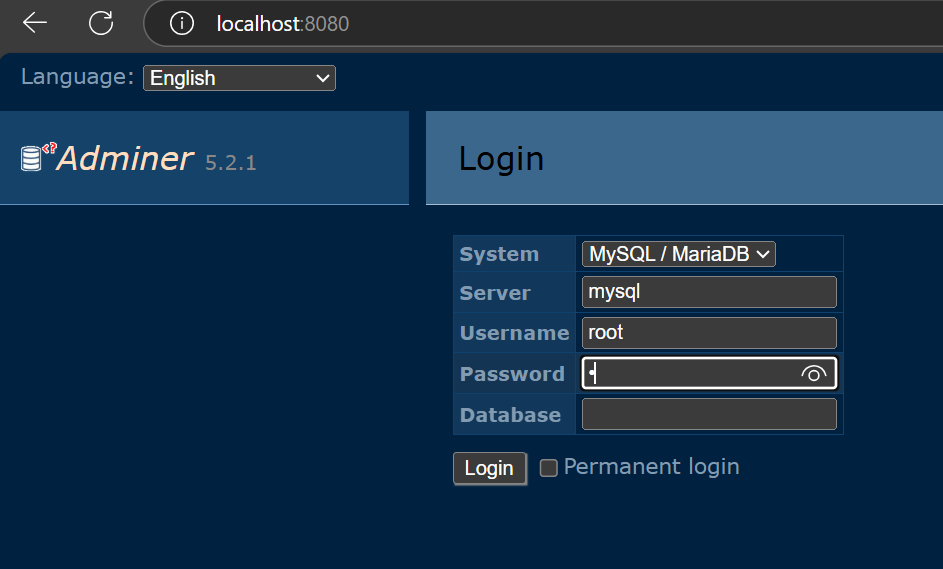


## You will get the following error

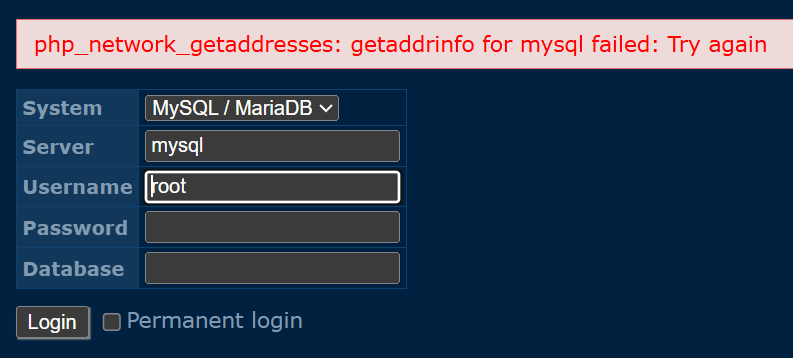

In [41]:
#Mac
# !docker inspect mysql | grep -n1 "IPAddress\":"
#Windows Needs to be run in cmd.exe or install bash to your windows system
#!docker inspect mysql | findstr 'IPAddress'

# or
print("-"*30)
show_container_ip("mysql")


------------------------------
mysql in network 'bridge' has IP: 172.17.0.2


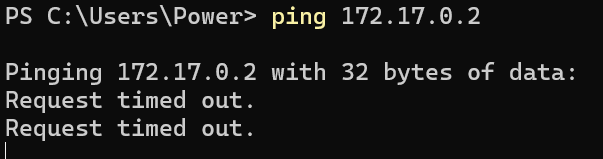

In [36]:
print("-"*30)
show_container_ip("adminer")


------------------------------
adminer in network 'bridge' has IP: 172.17.0.3


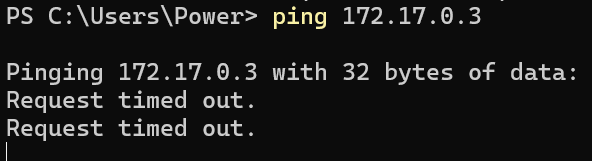


Notice that both are in bridge network and they both have an IP address

But the default bridge network is not setup to pass TCP traffic.

And because of this they are not able to talk to eachother. so lets cleanup and create our own network

### Lets do a bit of cleanup 

``` bash
#lets remove our old container
!docker stop adminer
!docker rm adminer
!docker stop mysql
!docker rm mysql
!docker stop nginx 
!docker rm nginx
```

In [42]:
def clean_containers():
    containers = client.containers.list(all=True)
    if not containers:
        print("No containers to clean.")
        return
    
    for container in containers:
        container.stop()        
        container.reload()
        if container.status == 'exited':
            print(f"Removing {container.name}")
            container.remove()

list_running_containers()

clean_containers()


adminer - running
mysql - running
nginx - running
Removing adminer
Removing mysql
Removing nginx


Notice now you are unable to login to adminer 

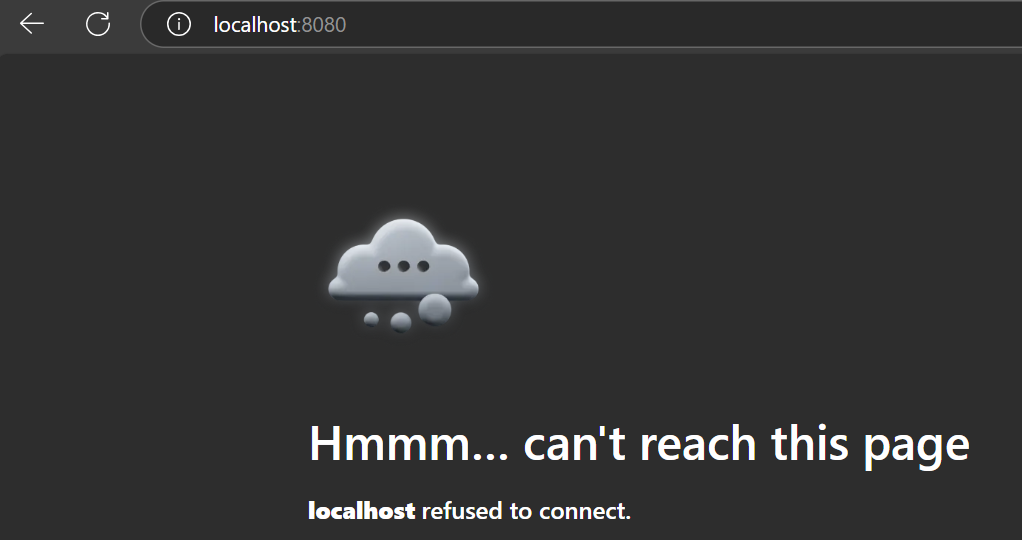

## Setting up the network

In [43]:
# Create a network called yourNetwork using the following command

!docker network create yourNetwork

Error response from daemon: network with name yourNetwork already exists


In [44]:
!docker network inspect yourNetwork

[
    {
        "Name": "yourNetwork",
        "Id": "73ce53181ae574ba5e9899d667fe02d47cf2b3af0fc293ecece140a4c83417eb",
        "Created": "2025-04-21T18:52:17.149280617Z",
        "Scope": "local",
        "Driver": "bridge",
        "EnableIPv6": false,
        "IPAM": {
            "Driver": "default",
            "Options": {},
            "Config": [
                {
                    "Subnet": "172.18.0.0/16",
                    "Gateway": "172.18.0.1"
                }
            ]
        },
        "Internal": false,
        "Attachable": false,
        "Ingress": false,
        "ConfigFrom": {
            "Network": ""
        },
        "ConfigOnly": false,
        "Containers": {},
        "Options": {},
        "Labels": {}
    }
]


In [45]:
!docker run -d --network yourNetwork --name mysql -p 3306:3306 -e MYSQL_ROOT_PASSWORD=1 mysql:8


efe82819ab0a639cfed2c16ba7678769713ef59a9dec8cf6e22729cff4fab7a7


In [46]:
!docker run -d --network yourNetwork --name adminer -p 8080:8080 adminer

6abf69191135d0e4250bbf94dde8dd69aaf526dece4eb8e9376f84fee2531e42


In [47]:
!docker ps

CONTAINER ID   IMAGE     COMMAND                  CREATED       STATUS         PORTS                               NAMES
6abf69191135   adminer   "entrypoint.sh docke…"   7 hours ago   Up 1 second    0.0.0.0:8080->8080/tcp              adminer
efe82819ab0a   mysql:8   "docker-entrypoint.s…"   7 hours ago   Up 3 seconds   0.0.0.0:3306->3306/tcp, 33060/tcp   mysql


In [ ]:
print("-"*30)
show_container_ip("mysql")
#was mysql in network 'bridge' has IP: 172.17.0.2

------------------------------
mysql in network 'yourNetwork' has IP: 172.18.0.2


In [ ]:
print("-"*30)
show_container_ip("adminer")
#WAS: adminer in network 'bridge' has IP: 172.17.0.3

------------------------------
adminer in network 'yourNetwork' has IP: 172.18.0.3


then login:

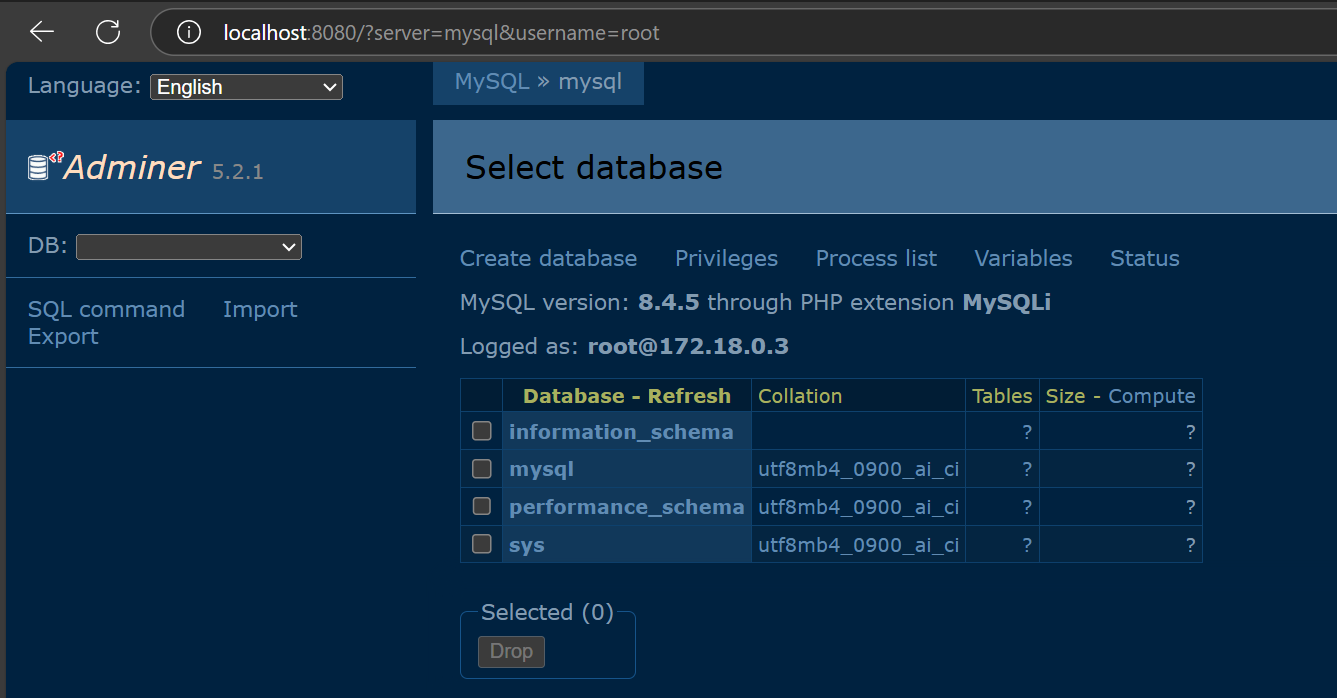



# LAB 
As a reminder you should be submitting to me 2 files. 
- _YourName_Lab 10.ipynb
    - this is your lab report
- _YourName__\<name of your script\>.py

## Part 1 - warm up

Now that you have 2 containers up and running and know there connected. Create a python script that will check to see if the IP addresses of the containers are up and running. 




## Part 2
Continue with the above code and create a script that will:
- Relaunch a container if it is ever shutdown. 
- Perform a maintenance restart after 1 day has passed. 

your python file does not need to be in a docker container


https://docs.docker.com/engine/api/sdk/examples/

